<a href="https://colab.research.google.com/github/ARD7989/AN-INTEGRATED-APPROACH-FOR-THE-DETECTION-OF-RETINAL-DISEASES-USING-CNN/blob/CNN/GlaucomaCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from glob import glob
from builtins import range, input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout

from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [3]:
IMAGE_SIZE = 224
batch_size = 16
normalization_factor = 255

glaucoma_positive_train_path = '/content/drive/MyDrive/Train_Positive'
glaucoma_negative_train_path = '/content/drive/MyDrive/Train_Negative'

glaucoma_positive_test_path = '/content/drive/MyDrive/Test_Positive'
glaucoma_negative_test_path = '/content/drive/MyDrive/Test_Negative'

glaucoma_positive_train_files = glob(glaucoma_positive_train_path + '/*')
glaucoma_negative_train_files = glob(glaucoma_negative_train_path + '/*')

glaucoma_positive_test_files = glob(glaucoma_positive_test_path + '/*')
glaucoma_negative_test_files = glob(glaucoma_negative_test_path + '/*')

In [4]:
glaucoma_positive_train_labels = []
glaucoma_negative_train_labels = []

glaucoma_positive_train_images=[]
glaucoma_negative_train_images=[]

glaucoma_positive_test_labels = []
glaucoma_negative_test_labels = []

glaucoma_positive_test_images=[]
glaucoma_negative_test_images=[]

for i in range(len(glaucoma_positive_train_files)):
  image = cv2.imread(glaucoma_positive_train_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_positive_train_images.append(image)
  glaucoma_positive_train_labels.append('Glaucoma Positive')

for i in range(len(glaucoma_negative_train_files)):
  image = cv2.imread(glaucoma_negative_train_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_negative_train_images.append(image)
  glaucoma_negative_train_labels.append('Glaucoma Negative')

for i in range(len(glaucoma_positive_test_files)):
  image = cv2.imread(glaucoma_positive_test_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_positive_test_images.append(image)
  glaucoma_positive_test_labels.append('Glaucoma Positive')

for i in range(len(glaucoma_negative_test_files)):
  image = cv2.imread(glaucoma_negative_test_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  glaucoma_negative_test_images.append(image)
  glaucoma_negative_test_labels.append('Glaucoma Negative')

In [5]:
glaucoma_positive_train_images = np.array(glaucoma_positive_train_images) / normalization_factor
glaucoma_negative_train_images = np.array(glaucoma_negative_train_images) / normalization_factor


glaucoma_positive_test_images = np.array(glaucoma_positive_test_images) / normalization_factor
glaucoma_negative_test_images = np.array(glaucoma_negative_test_images) / normalization_factor

In [6]:
X_train = np.concatenate((glaucoma_negative_train_images, glaucoma_positive_train_images), axis=0)
X_test = np.concatenate((glaucoma_negative_test_images, glaucoma_positive_test_images), axis=0)

y_train = np.concatenate((glaucoma_negative_train_labels, glaucoma_positive_train_labels), axis=0)
y_test = np.concatenate((glaucoma_negative_test_labels, glaucoma_positive_test_labels), axis=0)

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [13]:
inception = InceptionResNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [14]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=200)

Epoch 1/200
5/5 [==============================] - 16s 1s/step - loss: 6.7571 - accuracy: 0.5802 - val_loss: 12.1002 - val_accuracy: 0.4194
Epoch 2/200
5/5 [==============================] - 1s 247ms/step - loss: 7.5133 - accuracy: 0.6173 - val_loss: 8.9696 - val_accuracy: 0.5806
Epoch 3/200
5/5 [==============================] - 1s 330ms/step - loss: 3.8527 - accuracy: 0.7654 - val_loss: 7.4702 - val_accuracy: 0.4194
Epoch 4/200
5/5 [==============================] - 1s 277ms/step - loss: 4.0042 - accuracy: 0.6790 - val_loss: 5.0959 - val_accuracy: 0.6452
Epoch 5/200
5/5 [==============================] - 1s 246ms/step - loss: 4.6855 - accuracy: 0.6420 - val_loss: 2.2890 - val_accuracy: 0.5484
Epoch 6/200
5/5 [==============================] - 1s 297ms/step - loss: 2.7207 - accuracy: 0.7160 - val_loss: 1.8646 - val_accuracy: 0.6452
Epoch 7/200
5/5 [==============================] - 1s 242ms/step - loss: 2.1891 - accuracy: 0.7160 - val_loss: 2.2325 - val_accuracy: 0.8065
Epoch 8/200
5/

In [15]:
model.save('/content/drive/MyDrive/inception_resnet_v2_glaucoma.h5')
model.save_weights('/content/drive/MyDrive/inception_resnet_v2_glaucoma.hdf5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 4s 135ms/step


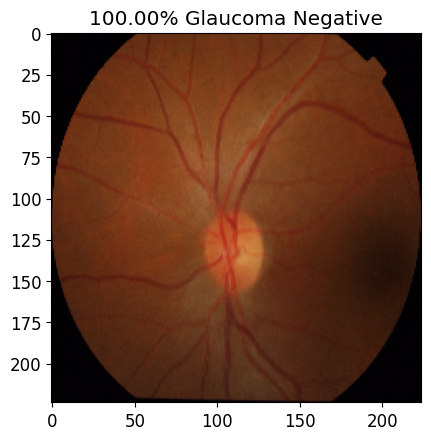

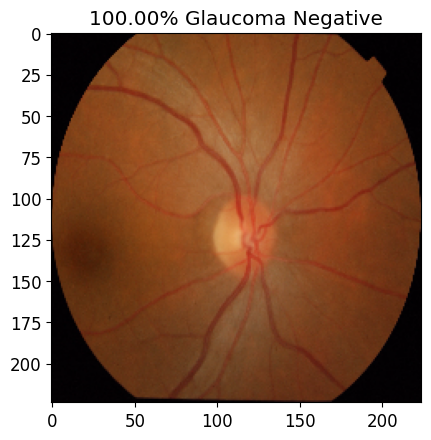

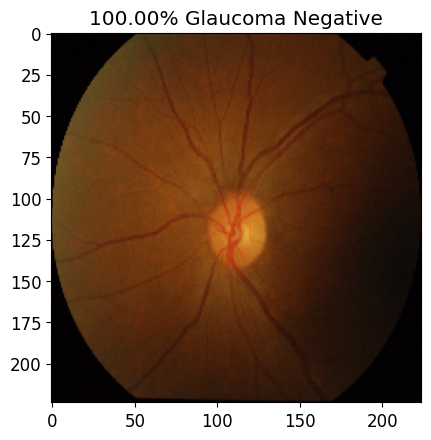

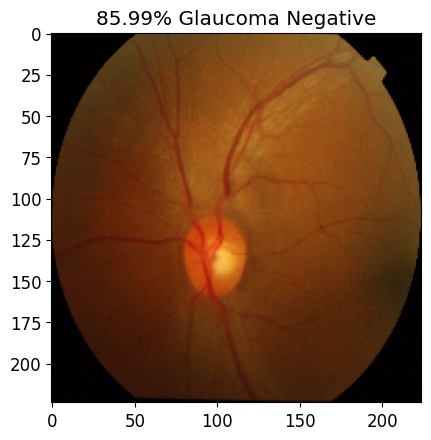

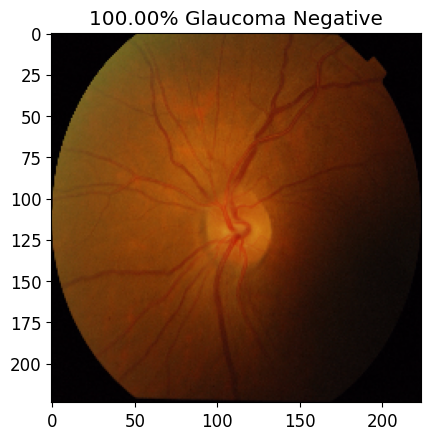

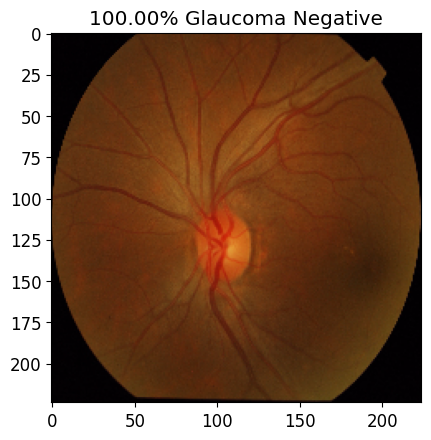

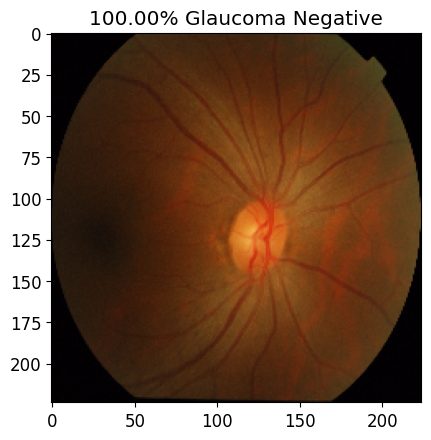

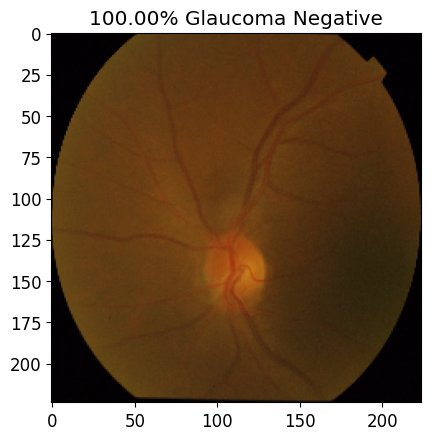

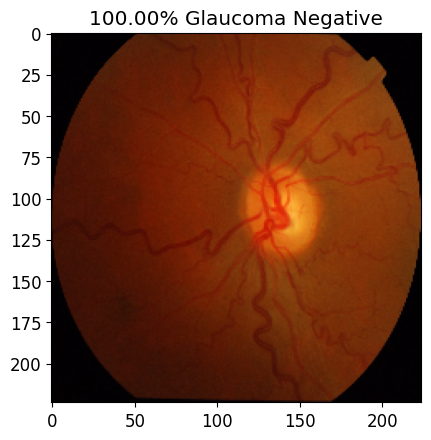

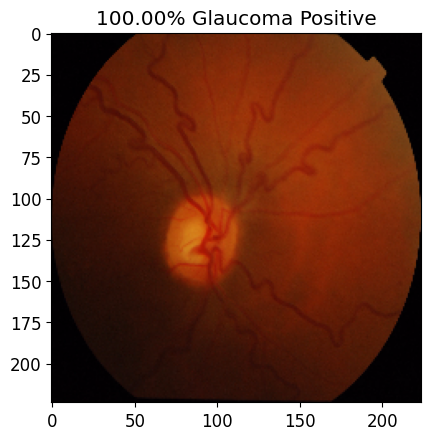

In [16]:
model = load_model('/content/drive/MyDrive/inception_resnet_v2_glaucoma.h5')
y_pred = model.predict(X_test, batch_size=batch_size)
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% Glaucoma Positive')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Glaucoma Negative')
  plt.imshow(X_test[index])
  plt.show()

In [17]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

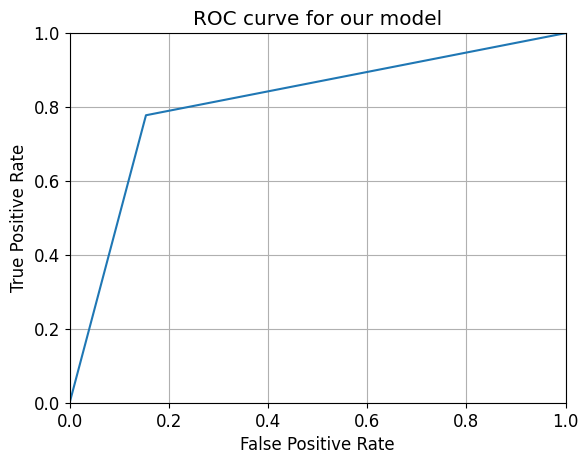

In [18]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


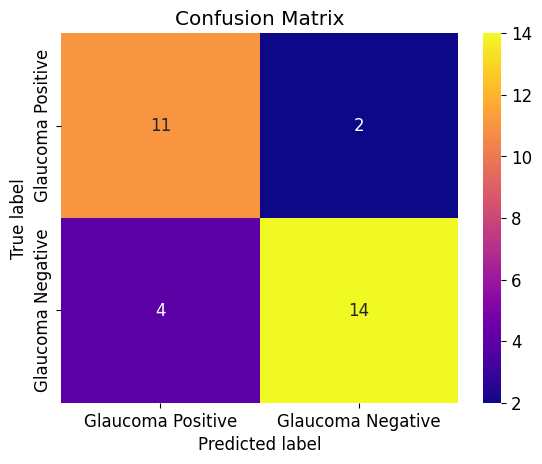

Confusion Matrix with Normalized Values


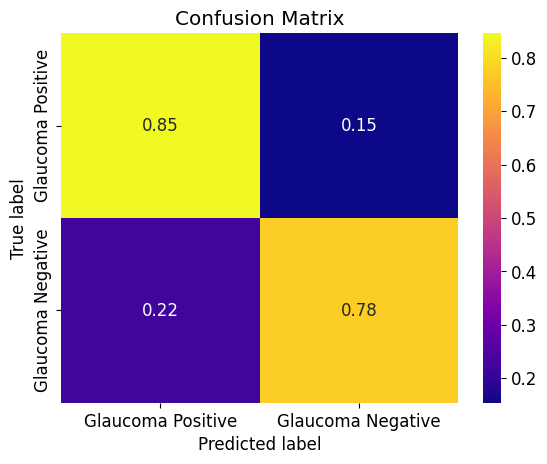

In [19]:
def plot_confusion_matrix(normalize):
  classes = ['Glaucoma Positive','Glaucoma Negative']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')